In [213]:
import sys

sys.path.append("..")
import random
from PIL import Image
import requests
from segment.utils import *
import yaml
from diffusers.utils import load_image, make_image_grid
import numpy as np
from ultralytics import YOLO
from segment.sam_results import SAMResults
from datasets import load_dataset
import random

yaml_file = "../configs/fashion_people_detection_no_person.yml"
with open(yaml_file, "r") as f:
    config = yaml.safe_load(f)

labels_dict = config.get("names")
labels_dict_reversed = {v: k for k, v in labels_dict.items()}

### A test notebook for seeing the results of a model after training

In [214]:
def unload(result):
    masks = result.masks.data
    boxes = result.boxes.xyxy
    scores = result.boxes.conf

    labels = result.boxes.cls
    labels = [int(label.item()) for label in labels]
    phrases = [labels_dict[label] for label in labels]
    return masks, boxes, scores, phrases

In [215]:
dataset_id = "MnLgt/fashion_people_detections_v2"

ds = load_dataset(
    dataset_id, split="train", trust_remote_code=True, cache_dir="../hf_cache"
)

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

In [302]:
model_path = "/home/ubuntu/SPAICE/SEGMENT/train_data/ultralytics/human_parsing_Sep_2024/train/weights/best.pt"
model = YOLO(model_path, task="segment")

Row Num: 1343


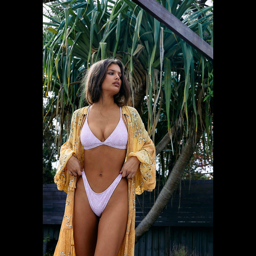

In [310]:
row_num = random.randint(0, len(ds))
row_num = 1343

print(f"Row Num: {row_num}")
row = ds[row_num]
image = row["image"]
image = resize_image_pil(image, 640)
image.resize((256, 256))

In [311]:
imgsz = max(image.size)
results = model(image, retina_masks=True, imgsz=imgsz)
result = results[0]


0: 640x640 1 hair, 1 face, 2 hands, 3 legs, 1 outfit, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


In [306]:
# 0: 1024x1024 1 hair, 1 face, 2 hands, 2 legs, 1 outfit, 7.2ms

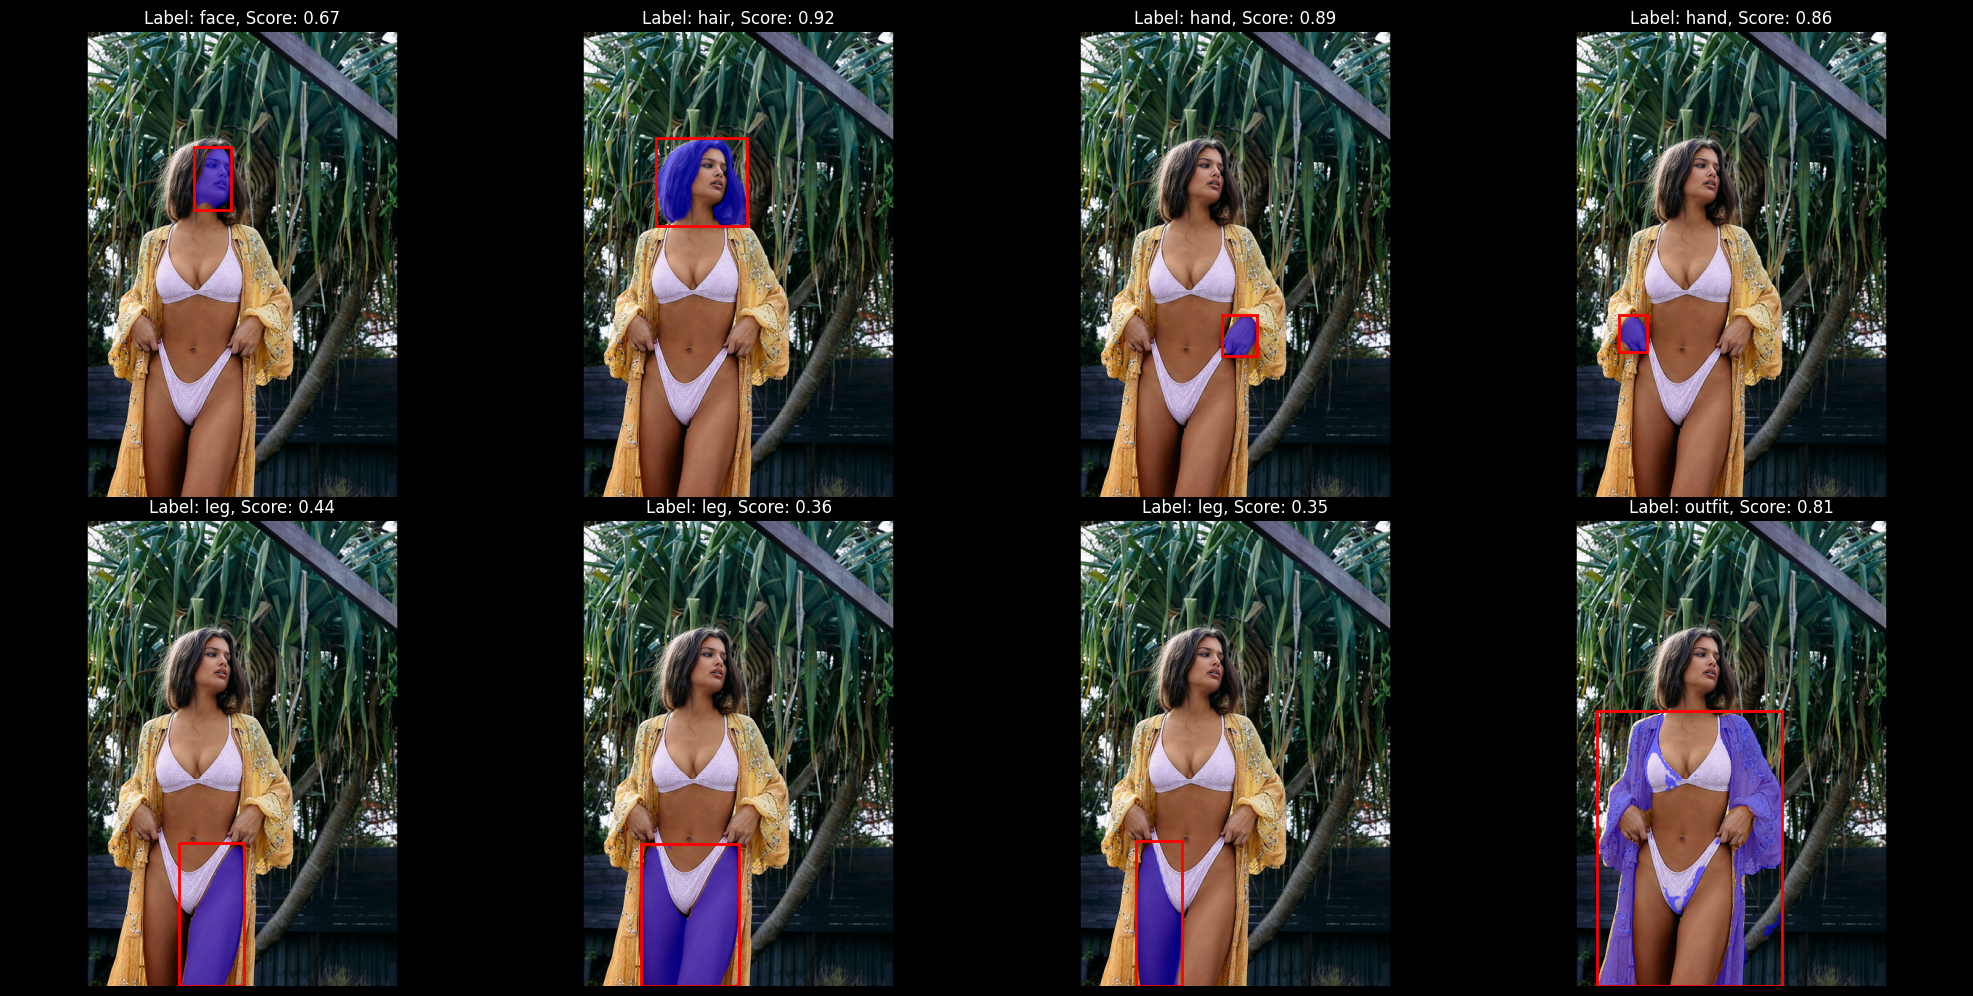

In [314]:
masks, boxes, scores, phrases = unload(result)
r = SAMResults(
    image,
    labels_dict_reversed,
    masks=masks,
    boxes=boxes,
    scores=scores,
    phrases=phrases,
    person_masks_only=False,
    labels_to_dedupe=None,
    overlap_threshold=0.8,)
r.display_results(prompt_label="label")

In [288]:
# row = r.get_mask("phone")[0]
# box = row.get('box')
# mask = row.get("mask")
# overlay = overlay_mask(image, mask, opacity=0.9)
# overlay.crop(box).resize((512,512))